In [2]:
import argparse
import h5py
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import xml.etree.ElementTree as etree
from fastmri_prostate.reconstruction.t2.prostate_t2_recon import t2_reconstruction
from fastmri_prostate.reconstruction.dwi.prostate_dwi_recon import dwi_reconstruction
from fastmri_prostate.data.mri_data import load_file_T2, load_file_dwi, save_recon
import warnings
import os
warnings.filterwarnings('ignore')


#! Below: Add full folder path to downloaded fastMRI prostate data
fastMRI_dir = "/DATASERVER/MIC/SHARED/NYU_FastMRI/Prostate/"

data_path_t2 = 'fastMRI_prostate_T2_IDS_001_020'
data_path_dwi = 'fastMRI_prostate_DIFF_IDS_001_011'

fname_t2 = os.path.join(fastMRI_dir, data_path_t2, 'file_prostate_AXT2_001.h5')
fname_t2 = Path("/DATASERVER/MIC/SHARED/NYU_FastMRI/Prostate/fastMRI_prostate_T2_IDS_294_312/file_prostate_AXT2_294.h5")

In [3]:
kspace, calibration_data, ismrmrd_header, reconstruction_rss, image_atts = load_file_T2(fname_t2)

print("Sizes of the array fields in the fastMRI prostate T2 file:")
print("kspace:", kspace.shape, ", calibration_data:", calibration_data.shape, ", reconstruction_rss:", reconstruction_rss.shape)

Sizes of the array fields in the fastMRI prostate T2 file:
kspace: (3, 30, 30, 640, 451) , calibration_data: (30, 30, 640, 32) , reconstruction_rss: (30, 320, 320)


Description of fields in the fastMRI prostate T2 file:

- "ismrmrd_header" => ISMRMRD header => scan acquisition parameters (https://ismrmrd.github.io/apidocs/1.5.0/)
- "kspace" => T2 raw k-space with dimensions => averages, slices, coils, readout, phase
- "reconstruction_rss" => Reconstructed T2 image volume with dimensions => slices, x, y
- "calibration_data" => Calibration scan acquired with dimensions => slices, coils, readout, phase

They all have reconstruction!

Difference between h5py.open() and load_fileT2?

In [ ]:
from typing import Dict, List, Optional, Sequence, Tuple
# this is what load_file_T2 does:
def load_file_T2_copy(fname: str) -> Tuple:
    """
    Load T2 fastmri file.
    
    Parameters:
    -----------
    fname : str
        Path to the h5 fastmri file.
    
    Returns:
    --------
    Tuple
        A tuple containing the kspace, calibration_data, hdr, im_recon, and attributes of the file.
    """

    with h5py.File(fname, "r") as hf:
        kspace = hf["kspace"][:]       
        calibration_data = hf["calibration_data"][:] 
        hdr = hf["ismrmrd_header"][()]
        im_recon = hf["reconstruction_rss"][:]   
        atts = dict()
        atts['max'] = hf.attrs['max']
        atts['norm'] = hf.attrs['norm']
        atts['patient_id'] = hf.attrs['patient_id']
        atts['acquisition'] = hf.attrs['acquisition']

    return kspace, calibration_data, hdr, im_recon, atts

kspace, calibration_data, ismrmrd_header, reconstruction_rss, image_atts = load_file_T2(fname_t2)


In [ ]:
import xmltodict

header = xmltodict.parse(hdr)
print(list(header.keys()))



def extract_keys(data, parent_key=""):
    keys = []
    for key, value in data.items():
        full_key = f"{parent_key}.{key}" if parent_key else key
        keys.append(full_key)
        if isinstance(value, dict):  # If it's a nested dictionary, recurse
            keys.extend(extract_keys(value, full_key))
        elif isinstance(value, list):  # If it's a list, check the first item
            if value and isinstance(value[0], dict):
                keys.extend(extract_keys(value[0], full_key))
    return keys

# Example usage
keys = extract_keys(header)

# Print all unique keys
for key in sorted(keys):
    print(key)


['ismrmrdHeader']
ismrmrdHeader
ismrmrdHeader.@xmlns
ismrmrdHeader.@xmlns:xs
ismrmrdHeader.@xmlns:xsi
ismrmrdHeader.@xsi:schemaLocation
ismrmrdHeader.acquisitionSystemInformation
ismrmrdHeader.acquisitionSystemInformation.coilLabel
ismrmrdHeader.acquisitionSystemInformation.coilLabel.coilName
ismrmrdHeader.acquisitionSystemInformation.coilLabel.coilNumber
ismrmrdHeader.acquisitionSystemInformation.deviceID
ismrmrdHeader.acquisitionSystemInformation.institutionName
ismrmrdHeader.acquisitionSystemInformation.receiverChannels
ismrmrdHeader.acquisitionSystemInformation.relativeReceiverNoiseBandwidth
ismrmrdHeader.acquisitionSystemInformation.systemFieldStrength_T
ismrmrdHeader.acquisitionSystemInformation.systemModel
ismrmrdHeader.acquisitionSystemInformation.systemVendor
ismrmrdHeader.encoding
ismrmrdHeader.encoding.encodedSpace
ismrmrdHeader.encoding.encodedSpace.fieldOfView_mm
ismrmrdHeader.encoding.encodedSpace.fieldOfView_mm.x
ismrmrdHeader.encoding.encodedSpace.fieldOfView_mm.y
ismrm

In [55]:
with h5py.File(fname_t2, "r") as hf:
    print("Keys in the HDF5 file:", list(hf.keys()))
    print("Attributes in the HDF5 file:", dict(hf.attrs))
    kspace = hf["kspace"][()]
print("kspace shape:", kspace.shape)

Keys in the HDF5 file: ['calibration_data', 'ismrmrd_header', 'kspace', 'reconstruction_rss']
Attributes in the HDF5 file: {'acquisition': 'AXT2', 'max': 0.0003349678, 'norm': 0.10631749, 'patient_id': '0294'}
kspace shape: (3, 30, 30, 640, 451)


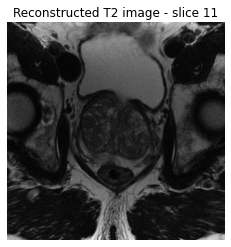

In [27]:
def display_t2_slice(img, slice_num):
    plt.imshow(img[slice_num, :, :] , cmap='gray')
    plt.title("Reconstructed T2 image - slice 11")
    plt.axis("off")
display_t2_slice(reconstruction_rss, 11)

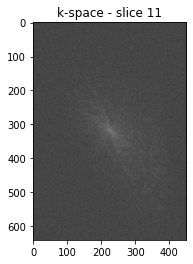

In [28]:
# plot kspace => fully sampled!
def plot_kspace(kspace, avg_num, slice_num, coil_num):
    plt.imshow(np.log(np.abs(kspace[avg_num, slice_num, coil_num, :, :])+ 1e-9), cmap='gray')
    plt.title("k-space - slice 11")

avg_num = 0
slice_num = 8
coil_num = 0
plot_kspace(kspace, avg_num, slice_num, coil_num)

kspace_avg0 shape: (30, 30, 640, 451)
kspace_slice_avg0 shape: (30, 640, 451)


(-0.5, 450.5, 639.5, -0.5)

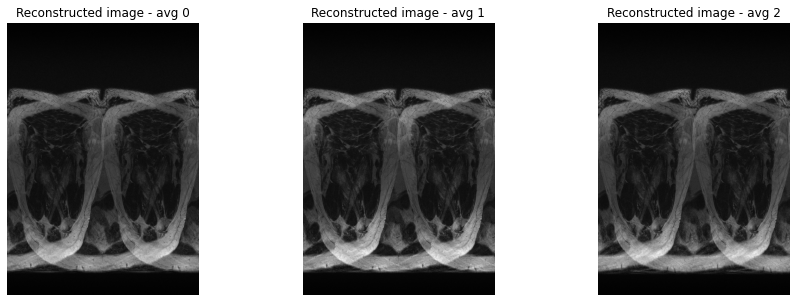

In [39]:
# split into the 3 averages
kspace_avg0 = kspace[0]
kspace_avg1 = kspace[1]
kspace_avg2 = kspace[2]
print("kspace_avg0 shape:", kspace_avg0.shape)

# select slice
slice_num = 1
kspace_slice_avg0 = kspace_avg0[slice_num]
kspace_slice_avg1 = kspace_avg1[slice_num]
kspace_slice_avg2 = kspace_avg2[slice_num]
print("kspace_slice_avg0 shape:", kspace_slice_avg0.shape)

# reconstruct rss image from the coils kspace
import fastmri
from fastmri.data import transforms as T

def reconstruct_kspace(kspace_slice_avg):
    kspace_slice_avg = T.to_tensor(kspace_slice_avg)
    img_slice_avg = fastmri.ifft2c(kspace_slice_avg)
    img_slice_avg_abs = fastmri.complex_abs(img_slice_avg)
    img_slice_avg_rss = fastmri.rss(img_slice_avg_abs, dim=0)
    return img_slice_avg_rss.numpy()

img_slice_avg0 = reconstruct_kspace(kspace_slice_avg0)
img_slice_avg1 = reconstruct_kspace(kspace_slice_avg1)
img_slice_avg2 = reconstruct_kspace(kspace_slice_avg2)

# plot the reconstructed images next to each other

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_slice_avg0, cmap='gray')
plt.title("Reconstructed image - avg 0")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(img_slice_avg1, cmap='gray')
plt.title("Reconstructed image - avg 1")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(img_slice_avg2, cmap='gray')
plt.title("Reconstructed image - avg 2")
plt.axis("off")


(-0.5, 450.5, 639.5, -0.5)

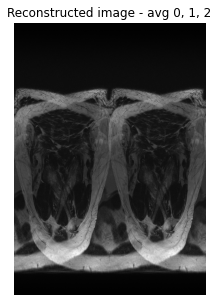

In [40]:
# combine the 3 averages into one image
im_3d = np.mean(np.array([img_slice_avg0, img_slice_avg1, img_slice_avg2]), axis=0)
plt.figure(figsize=(5, 5))
plt.imshow(im_3d, cmap='gray')
plt.title("Reconstructed image - avg 0, 1, 2")
plt.axis("off")

## Select test files

In [4]:
# try selecting all T2 folders in fastmri_dir
def get_t2_filenames(fastMRI_dir):
    t2_folders = [f for f in os.listdir(fastMRI_dir) if 'T2' in f]
    t2_files = []
    for folder in t2_folders:
        folder_path = os.path.join(fastMRI_dir, folder)
        for file in os.listdir(folder_path):
            if file.endswith('.h5'):
                t2_files.append(os.path.join(folder_path, file))
    return t2_files

print("T2 files found:", len(get_t2_filenames(fastMRI_dir)))

# compute amount of slices in the first 140 T2 files
def compute_slices_in_t2_files(fastMRI_dir, num_files):
    t2_files = get_t2_filenames(fastMRI_dir)
    total_slices = 0
    for i, file in enumerate(t2_files):
        if i >= num_files:
            break
        with h5py.File(file, 'r') as f:
            total_slices += f['kspace'].shape[1]
    return total_slices

total_slices = compute_slices_in_t2_files(fastMRI_dir, num_files=139)
print(f"Total number of slices in the first 139 T2 files: {total_slices}")

T2 files found: 253
Total number of slices in the first 139 T2 files: 4222


In [5]:
# Check if calling twice gives the same result
total_slices_check = compute_slices_in_t2_files(fastMRI_dir, num_files=139)
print(f"Total number of slices in the first 139 T2 files (check): {total_slices_check}")
# Check if the two results are equal
if total_slices == total_slices_check:
    print("The two results are equal.")

Total number of slices in the first 139 T2 files (check): 4222
The two results are equal.
